# Analyse des décès en France (toutes causes confondues)
Ce notebook a pour but de mettre les chiffres de décès de 2020 en France en perspective afin d'en tirer des conclusions éclairées.

In [1]:
# Bibliothèque d'analyse et de traitement de données
import pandas as pd
from pandas.api.types import CategoricalDtype
print("Pandas version :", pd.__version__)
import numpy as np
from datetime import datetime
# Bibliothèques de gestion des graphiques
import matplotlib.pyplot as plt
# Bibliothèques de gestion des fichiers
import glob
import os.path
# Bibliothèque de gestion du format csv pour écrire les fichiers cache
import csv
# "Constantes" ou variables globales
csv_delimiter = ';'
print ('Imports des bibliothèques terminés !')

Pandas version : 1.1.3
Imports des bibliothèques terminés !


# Données sources
Les données sources sont issues du __[Fichier des personnes décédées](https://www.data.gouv.fr/fr/datasets/fichier-des-personnes-decedees/)__ fournies en données ouvertes sur [data.gouv.fr](https://www.data.gouv.fr/fr/).

Les fichiers `deces-*.txt` doivent être téléchargés dans le dossier de travail du notebook.
Pour un traitement rapide, commencer par un petit nombre de fichiers, ex: 2002 et 2003.

**note** : Certains fichiers portent parfois quelques "caractères non imprimables" qui font échouer sa lecture et son interprétation. Dans ce cas, il faut l'éditer pour rechercher et retirer ces caractères. Je ne sais pas si c'est un problème du fichier d'origine ou si c'est dû à un parasitage du téléchargement, je n'ai pas investigué.

## Analyse et extraction
Pour accélérer le travail, nous alons lire les fichiers `deces-*.txt` qui ont un format "en largeur fixe" et en extraire les informations essentielles suivantes :
 - date de décès
 - date de naissance
 
Ces informations seront écrites dans un fichier cache au format CSV qui permettra plusieurs choses :
 1. Accélérer une éventuelle relecture des données sources : au lieu de lire pour chaque année un fichier de plus de 100 Mo, on ne lit que quelques Mo.
 1. Manipuler ces données dans un tableur indépendamment de cet exercice à des fins de recoupement, par exemple.
 1. Porter directement l'âge du décès par soustraction plutôt que la date de naissance pour éviter de refaire le calcul à chaque utilisation de la donnée.
 
Pour que le code soit compréhensible, je laisse un certain nombre de variables intermédiaires.

In [2]:
# Lister tous les fichiers qui commencent par "deces" et sont au format texte (finissent par ".txt")
sourcelist = [f for f in glob.glob("deces*.txt")]
# Pour chaque fichier de cette liste...
for source in sourcelist:
    # on va créer un pendant au même nom, mais se terminant par .csv
    cachefile = source[0:-4] + '.csv'
    # Par contre, on ne crée ce fichier que s'il n'existe pas ou s'il est plus vieux que le fichier de données
    if not(os.path.exists(cachefile)) or os.path.getmtime(source) > os.path.getmtime(cachefile):
        if os.path.exists(cachefile):
            os.remove(cachefile)
        with open(cachefile, 'w', newline='') as cache:
            cache_writer = csv.writer(cache, delimiter = csv_delimiter, quotechar='"', quoting=csv.QUOTE_MINIMAL)
            print ('Génération du cache CSV pour le fichier : ' + source)
            # On crée une première ligne portant le nom des 2 colonnes
            cache_writer.writerow(['date', 'age'])
            # On ouvre ensuite le fichier source pour en lire toutes ses lignes en gérant les caractères accentués
            with open(source,'r', errors='replace') as f:
                lines = f.readlines()
            # Pour chaque ligne du fichier source...
            for l in lines:
                # ...on interprète la date de décès aux caractères 154 à 161 inclus (donc 162 exclus)
                txt_date_d = l[154:162]
                try:
                    date_d = datetime.strptime(txt_date_d, "%Y%m%d")
                except ValueError:
                    # Si la date n'est pas interprétable, alors on met zero
                    date_d = 0
                    continue
                # ...on interprète la date de naissance aux caractères 81 à 88
                try:
                    date_n = datetime.strptime(l[81:89], "%Y%m%d")
                except ValueError:
                    # Si la date n'est pas interprétable, alors on met zero
                    date_n = 0
                    continue
                # Ici, on peut choisir de filtrer.
                # Par exemple, on peut choisir de ne conserver que les années 20xx et 199x
                # Mais surtout, on ignore les dates non reconnues
                if date_d != 0 and date_n != 0 and (txt_date_d[0:2] == '20' or txt_date_d[0:3] == '199'):
                    # Puis on calcule l'âge qu'on écrit avec la date de décès dans le fichier csv
                    age = date_d.year - date_n.year - ((date_d.month, date_d.day) < (date_n.month, date_n.day))
                    cache_writer.writerow([txt_date_d[0:4]+'/'+txt_date_d[4:6]+'/'+txt_date_d[6:8],age])
print ('(Ré)génération des caches CSV terminée !')

(Ré)génération des caches CSV terminée !


## Relecture du cache
Ci-après, on lit tous les fichiers cache pour les concaténer en mémoire afin de faire notre analyse.

Pour réinitialiser toutes les données de la "dataframe" df, c'est cette cellule qu'il faut réexécuter.

In [3]:
print ('Lecture des fichiers cache...')
# Créer une liste de tous les csv
chunks = []
cachelist = [f for f in glob.glob("deces*.csv")]
for cache in cachelist:
    # print ('Lecture de :', cache)
    chunks.append(pd.read_csv(cache,
                              sep=';',
                              encoding='latin_1',        # Spécifie l'encodage du fichier à lire
                              dtype={'age':np.int8},     # Stocke l'age dans un format court pour la performance
                              index_col=['date'],        # Crée un indexe sur la colonne date
                              parse_dates=True))         # Interprète automatiquement ce qui ressemble à une date
# Concatène le tout
df = pd.concat(chunks, axis=0, ignore_index=False)
# Affiche les premières lignes pour vérifier que tout s'est bien passé
df.tail()
# Exemples d'utilisation :
#  * Sélection de tous les décès à moins de 50 ans : df[df.age < 50]
#  * Sélection de tous les décès du mois de février 2020 : df.loc['2020-02']

Lecture des fichiers cache...


,age
date,
2020-03-23,83
2020-03-07,78
2020-03-25,52
2020-04-11,56
2020-03-31,77


## Classification
Pour se simplifier l'interprétation graphique, on va classer chaque décès dans une catégorie d'âge.

J'ai découpé en tranches plus ou moins fines...

In [4]:
df['classe'] = pd.cut(df.age, bins=[0, 18, 25, 45, 55, 65, 75, 85, 150],
                      labels=['mineur', '18-25 ans', '26-45 ans', '46-55 ans', '56-65 ans', '66-75 ans', '76-85 ans', 'plus de 86 ans'])
df.tail()

,age,classe
date,,
2020-03-23,83,76-85 ans
2020-03-07,78,76-85 ans
2020-03-25,52,46-55 ans
2020-04-11,56,56-65 ans
2020-03-31,77,76-85 ans


## Nombre de décès par date par catégorie
A partir de la dataframe contenant les catégories, on crée une matrice pour compter le nombre de décès par date par catégorie. 

In [5]:
ages_df = df.groupby(['date', 'classe']).age.count().astype(np.int16).unstack()
ages_df.tail()

classe,mineur,18-25 ans,26-45 ans,46-55 ans,56-65 ans,66-75 ans,76-85 ans,plus de 86 ans
date,,,,,,,,
2020-09-25,2,3,19,49,100,192,277,469
2020-09-26,5,2,21,48,92,166,225,417
2020-09-27,0,0,15,27,65,150,190,394
2020-09-28,2,0,4,21,64,125,151,320
2020-09-29,0,0,1,5,11,16,33,50


# Analyses graphiques
## Analyse graphique par classe d'âge durant le confinement en France
Afin de rendre la courbe plus lisible (la débruiter), on utilise une fonction de lissage ewm moyenné avec un facteur alpha assez faible.
Analysons la période du confinement élargie de mars à mai.
Constate-t-on que pour la population au dessous de 65 ans, ne nombre de décès n'a pas varié de façon notable ?

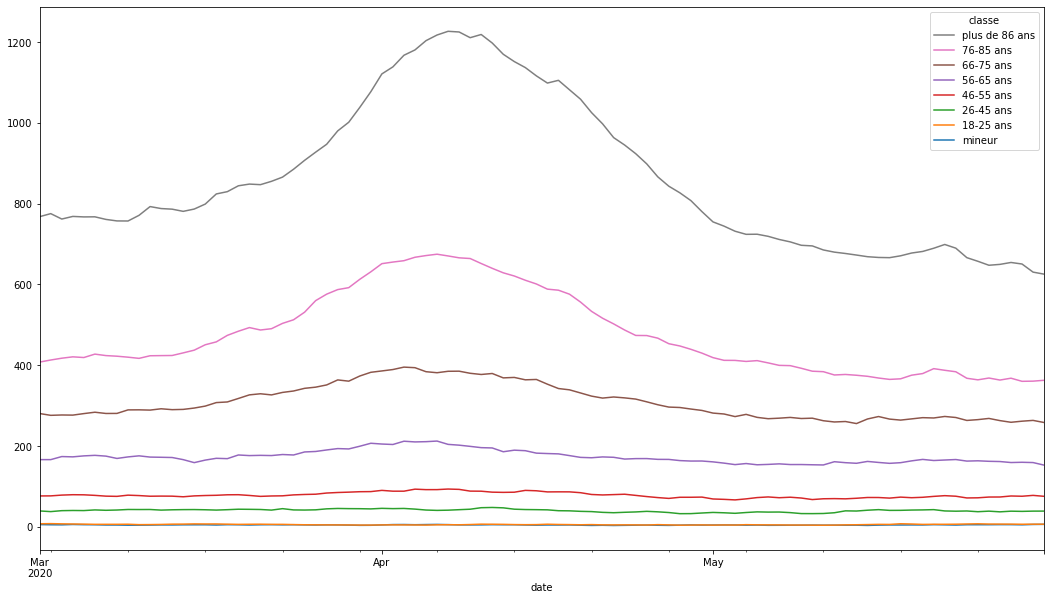

In [6]:
# Pour supprimer le lissage, mettre alpha=1
# _= est une petite astuce de Romain WaaY pour ne pas afficher de message parasite avec le graphique
_=ages_df.ewm(alpha=0.2).mean().loc['2020-03':'2020-05'].plot(figsize=(18,10), legend='reverse')

## Analyse graphique sur les 20 dernières années
Mettons maintenant en perspective la surmortalité du printemps 2020 par rapport aux 20 dernières années, toutes classes d'âge confondues.

D'une manière générale, on constate des pics de décès de plus en plus hauts tous les 2 à 4 ans.

Le pic de 2020 est élevé, mais semble rester dans la tendance haussière générale...

<AxesSubplot:xlabel='date'>

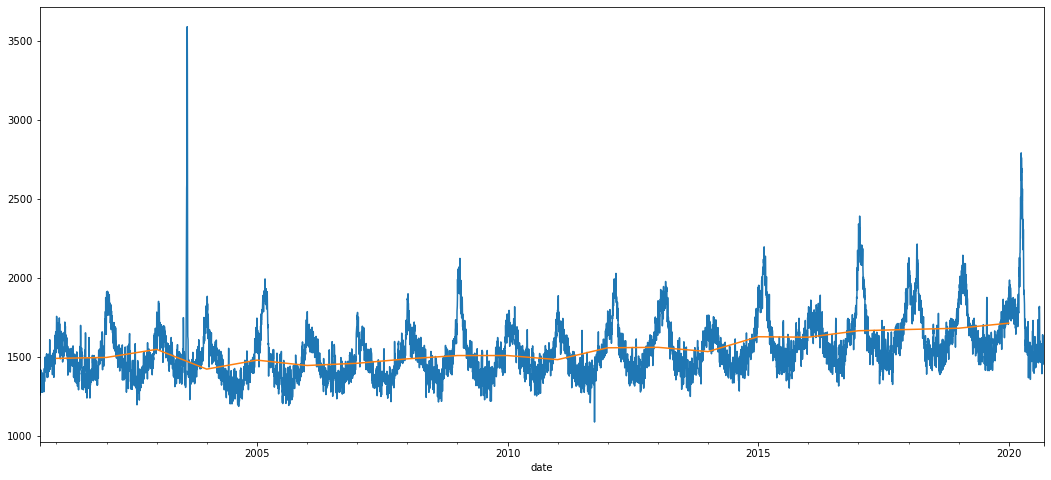

In [7]:
_=df.loc['2000-09':'2020-09-15'].classe.groupby('date').count().plot(figsize=(18,8))
# Calcul des moyennes annuelles
an_debut = 2001
an_fin = 2021
moyennes = pd.Series([int(ages_df.loc[str(an)].mean().sum()) for an in range(an_debut,an_fin)],
                     index=[datetime.strptime(str(an), "%Y") for an in range(an_debut,an_fin)])
moyennes.plot()

In [8]:
#Todo: superposer les courbes
#plt.figure(figsize=(18,8))
#df.loc['2009-09'].classe.groupby('date').count().plot()
#df.loc['2010-09'].classe.groupby('date').count().plot()

In [9]:
ddf = pd.DataFrame(df.classe.groupby('date').count())
ddf.tail()

,classe
date,
2020-09-25,1111
2020-09-26,976
2020-09-27,841
2020-09-28,687
2020-09-29,116


<AxesSubplot:xlabel='date'>

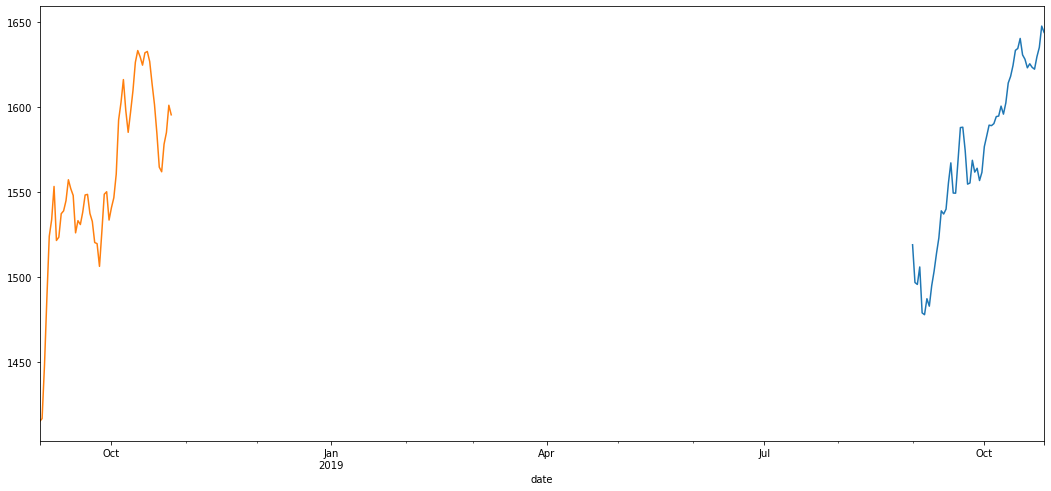

In [10]:
#Todo: superposer les courbes
plt.figure(figsize=(18,8))
df.loc['2019-09-01':'2019-10-26'].classe.groupby('date').count().ewm(alpha=0.2).mean().plot()
df.loc['2018-09-01':'2018-10-26'].classe.groupby('date').count().ewm(alpha=0.2).mean().plot()

In [11]:
ddf['annee'] = ddf.index.year
ddf['doy'] = ddf.index.dayofyear
ddf.tail()

,classe,annee,doy
date,,,
2020-09-25,1111,2020,269
2020-09-26,976,2020,270
2020-09-27,841,2020,271
2020-09-28,687,2020,272
2020-09-29,116,2020,273


In [12]:
ddf.reset_index(inplace=True)
ddf.set_index(['annee', 'doy'], inplace=True)
ddf

date  classe
annee doy                   
1990  1   1990-01-01       4
      2   1990-01-02       1
      3   1990-01-03       1
      4   1990-01-04       1
      5   1990-01-05       2
...              ...     ...
2020  269 2020-09-25    1111
      270 2020-09-26     976
      271 2020-09-27     841
      272 2020-09-28     687
      273 2020-09-29     116

[11059 rows x 2 columns]

<AxesSubplot:xlabel='doy'>

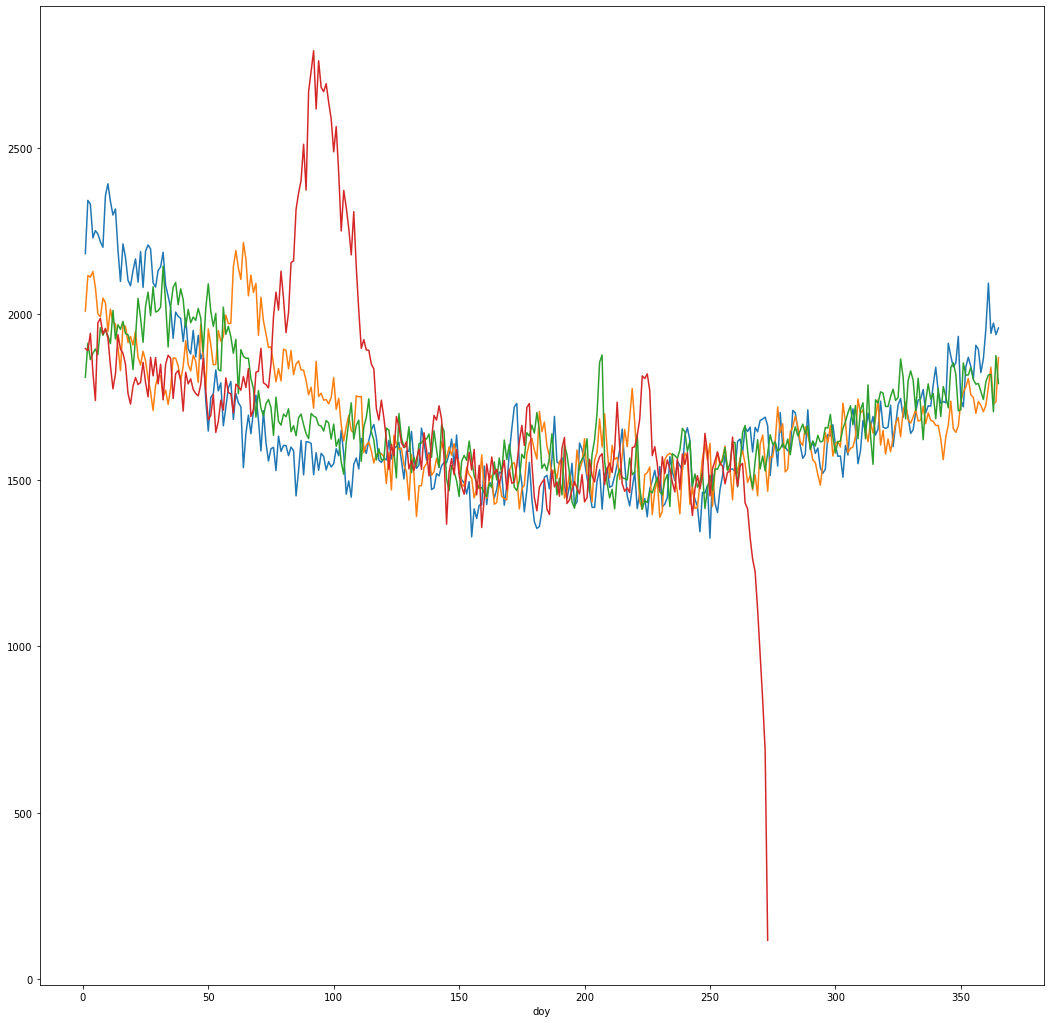

In [13]:
plt.figure(figsize=(18,18))
ddf.loc[2017].classe.plot(x=ddf.date)
ddf.loc[2018].classe.plot(x=ddf.date)
ddf.loc[2019].classe.plot(x=ddf.date)
ddf.loc[2020].classe.plot(x=ddf.date)

In [14]:
ds2020 = pd.read_csv('2020-11-06_detail\DC_2020_det.csv', sep=';', encoding='utf-8')
ds2020 = ds2020.drop(['COMDEC', 'DEPDEC', 'SEXE', 'COMDOM', 'LIEUDEC2'], axis=1)
nb_lignes_brut = ds2020.shape[0]
ds2020 = ds2020.dropna(axis=0)
print ("Nombre de lignes incomplètes retirées :", str(nb_lignes_brut - ds2020.shape[0]))
ds2020.tail()

Nombre de lignes incomplètes retirées : 4154


,ADEC,MDEC,JDEC,ANAIS,MNAIS,JNAIS
540425,2020,11,2,1930,5.0,12.0
540426,2020,11,2,1970,9.0,19.0
540427,2020,11,2,1939,3.0,6.0
540428,2020,11,2,1926,2.0,6.0
540429,2020,11,2,1926,12.0,25.0


In [15]:
ds2020['MNAIS'] = ds2020['MNAIS'].astype('int64')
ds2020['JNAIS'] = ds2020['JNAIS'].astype('int64')
ds2020['age'] = ds2020['ADEC'] - ds2020['ANAIS'] - (ds2020['MDEC'] < ds2020['MNAIS'])
ds2020.drop(['ANAIS', 'MNAIS', 'JNAIS'], axis=1, inplace=True)
ds2020.tail()

,ADEC,MDEC,JDEC,age
540425,2020,11,2,90
540426,2020,11,2,50
540427,2020,11,2,81
540428,2020,11,2,94
540429,2020,11,2,93


In [16]:
ds2020['classe'] = pd.cut(ds2020.age, bins=[0, 18, 25, 45, 55, 65, 75, 85, 150],
                          labels=['mineur', '18-25 ans', '26-45 ans', '46-55 ans', '56-65 ans', '66-75 ans', '76-85 ans', 'plus de 86 ans'])
#ds2020['date'] = pd.to_datetime(str(ds2020['ADEC'])+'-'+str(ds2020['MDEC'])+'-'+str(ds2020['JDEC']), format='%y-%m-%d')
ds2020.rename(columns={"ADEC": "year", "MDEC": "month", "JDEC": "day"}, inplace = True)
ds2020['date'] = pd.to_datetime(ds2020.loc[:,['year', 'month', 'day']])
ds2020.tail()

,year,month,day,age,classe,date
540425,2020,11,2,90,plus de 86 ans,2020-11-02
540426,2020,11,2,50,46-55 ans,2020-11-02
540427,2020,11,2,81,76-85 ans,2020-11-02
540428,2020,11,2,94,plus de 86 ans,2020-11-02
540429,2020,11,2,93,plus de 86 ans,2020-11-02


In [17]:
ds2020.drop(['month', 'day', 'age'], axis=1, inplace = True)
ds2020.rename(columns={"year": "annee"}, inplace = True)
ds2020.set_index('date', inplace=True)
ds2020.tail()

,annee,classe
date,,
2020-11-02,2020,plus de 86 ans
2020-11-02,2020,46-55 ans
2020-11-02,2020,76-85 ans
2020-11-02,2020,plus de 86 ans
2020-11-02,2020,plus de 86 ans


In [18]:
dds = pd.DataFrame(ds2020.classe.groupby('date').count())
dds.tail()
dds['annee'] = dds.index.year
dds['doy'] = dds.index.dayofyear
dds.reset_index(inplace=True)
dds.set_index(['annee', 'doy'], inplace=True)
dds.tail()

date  classe
annee doy                   
2020  303 2020-10-29    2003
      304 2020-10-30    1959
      305 2020-10-31    1927
      306 2020-11-01    1990
      307 2020-11-02    2007

<AxesSubplot:xlabel='doy'>

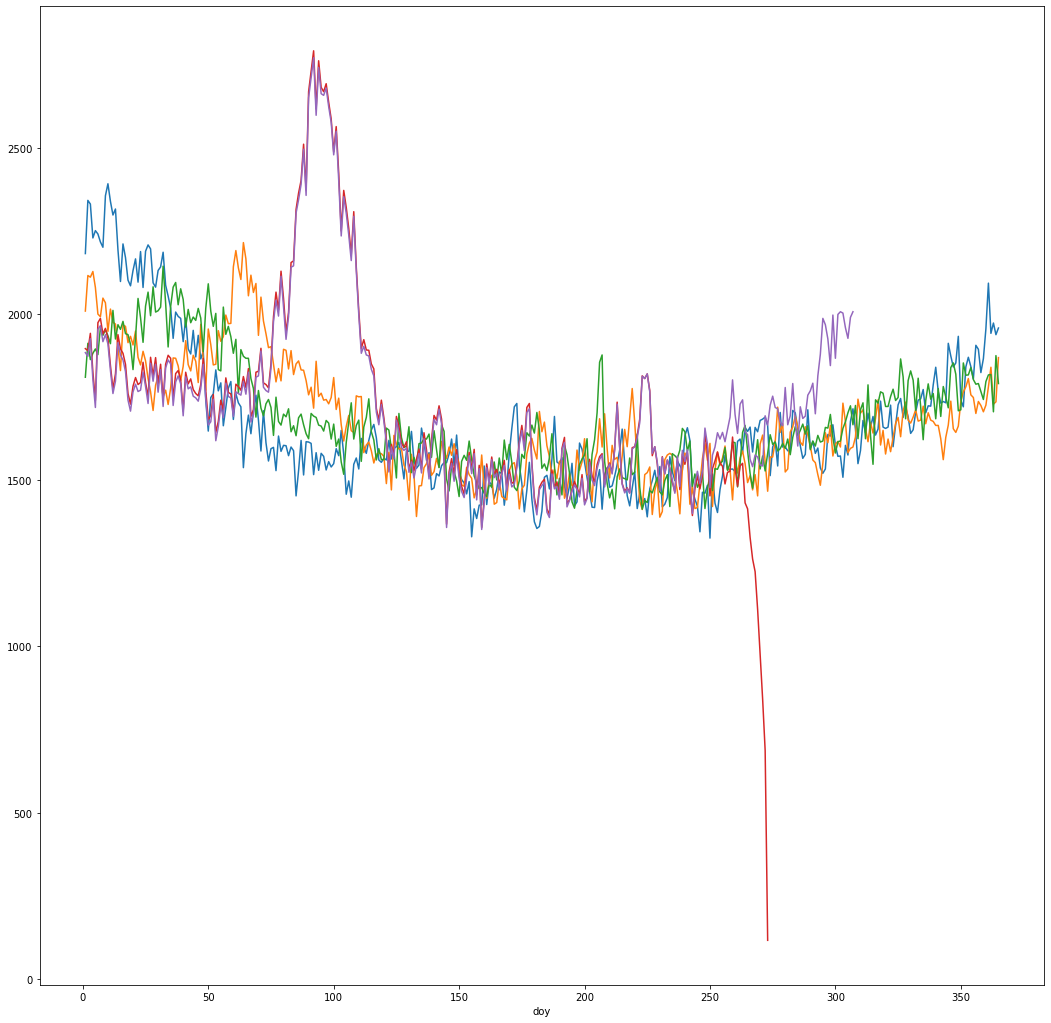

In [19]:
plt.figure(figsize=(18,18))
#ddf.loc[2010].classe.plot(x=ddf.date)
#ddf.loc[2011].classe.plot(x=ddf.date)
#ddf.loc[2012].classe.plot(x=ddf.date)
#ddf.loc[2013].classe.plot(x=ddf.date)
#ddf.loc[2014].classe.plot(x=ddf.date)
#ddf.loc[2015].classe.plot(x=ddf.date)
#ddf.loc[2016].classe.plot(x=ddf.date)
ddf.loc[2017].classe.plot(x=ddf.date)
ddf.loc[2018].classe.plot(x=ddf.date)
ddf.loc[2019].classe.plot(x=ddf.date)
ddf.loc[2020].classe.plot(x=ddf.date)
dds.loc[2020].classe.plot(x=ddf.date)

In [20]:
##### fig, ax = plt.subplots(figsize=(18,10))
ax.set_ylim(bottom=1000, top=3000)
doy = range(1,367)
#ddf[['2017','2018','2019','2020']].plot(ax=ax)
#ddf.loc[2019].classe.plot(ax=ax)
#dds.loc[2020].classe.plot(ax=ax)
c2019 = ax.plot((doy, ddf.loc[2019].classe))
c2020 = ax.plot((doy, dds.loc[2020].classe))
ax_age.legend((c2019, c2020), ('2019', '2020'), loc='upper right')
ax.set_xlabel('jour de l''année')
ax.set_ylabel('nombre de décès par jour')
ax.set_title('Courbes annuelles de décès en France')

NameError: name 'ax' is not defined